NAIROBI OZONESONDE DATA AVAILABILITY

Total launches from 1998 to 2024: 1044


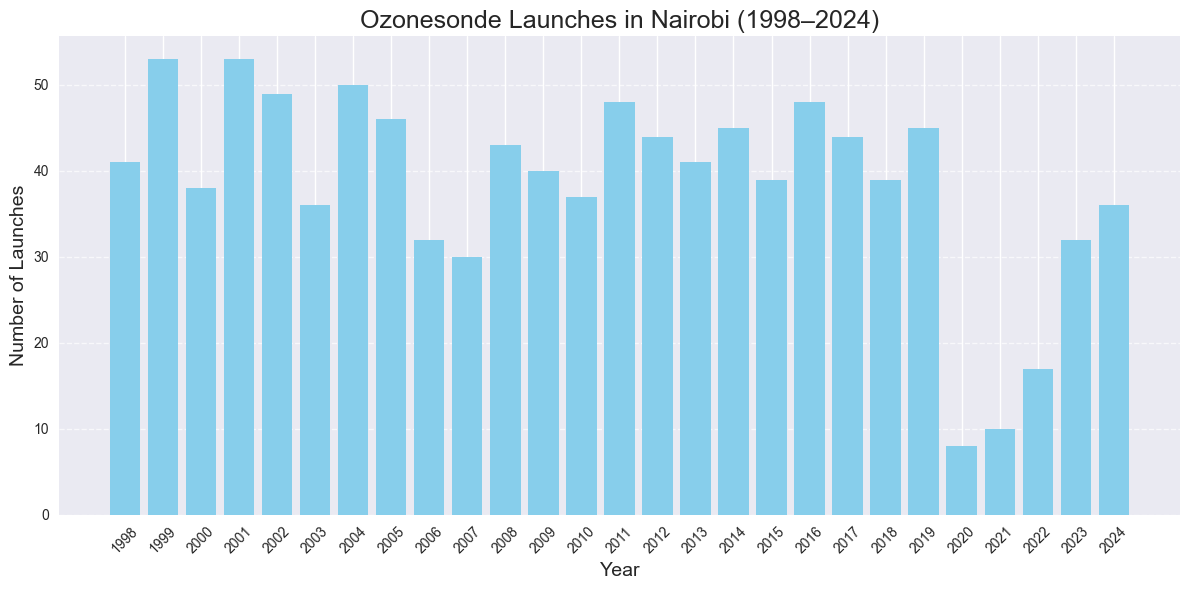

In [32]:
import os
import matplotlib.pyplot as plt

# data Configuration
base_dir = "Ozonesondes"
start_year, end_year = 1998, 2024

years = sorted({
    int(tok)
    for d in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, d))
    for tok in d.split("_")
    if tok.isdigit() and start_year <= int(tok) <= end_year
})

# Count launches per year
launch_counts = []
for year in years:
    year_folder = f"shadoz_nairobi_{year}_V06"
    path = os.path.join(base_dir, year_folder)
    try:
        files = [f for f in os.listdir(path)
                 if os.path.isfile(os.path.join(path, f))]
        count = len(files)
    except FileNotFoundError:
        count = 0
    launch_counts.append(count)

# Total count calculation
total_launches = sum(launch_counts)
print(f"Total launches from {start_year} to {end_year}: {total_launches}")

# Plotting 
plt.style.use("seaborn-v0_8")
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(years, launch_counts, color="skyblue")
ax.set_title("Ozonesonde Launches in Nairobi (1998–2024)", fontsize=18)
ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("Number of Launches", fontsize=14)

ax.set_xticks(years)
ax.set_xticklabels(years, rotation=45, fontsize=10)
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


OZONE & TEMPERATURE VERTICAL PROFILES FOR 30TH OCT 2024

      GeopAlt   Temp  O3_mPa
0       1.790  25.00  3.4211
1       1.803  23.67  3.4606
2       1.806  23.58  3.4606
3       1.810  23.42  3.4607
4       1.813  23.30  3.4607
...       ...    ...     ...
7076   33.193 -37.98  6.7099
7077   33.193 -37.93  6.7099
7078   33.202 -37.87  6.6709
7079   33.202 -37.80  6.6312
7080   33.212 -37.71  6.6318

[7081 rows x 3 columns]
Extracted 7081 rows and 3 columns


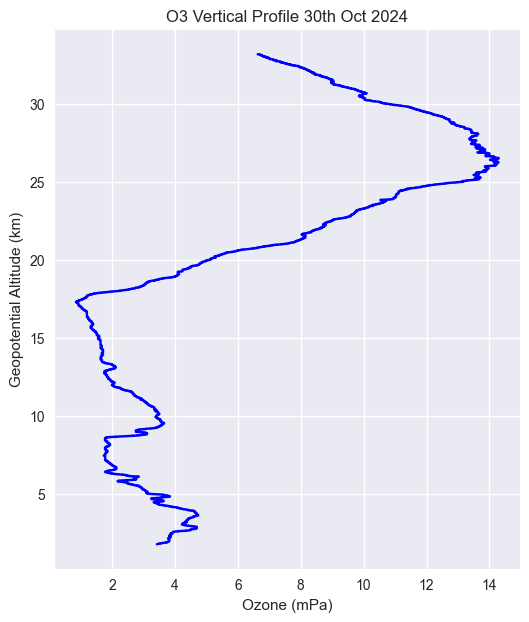

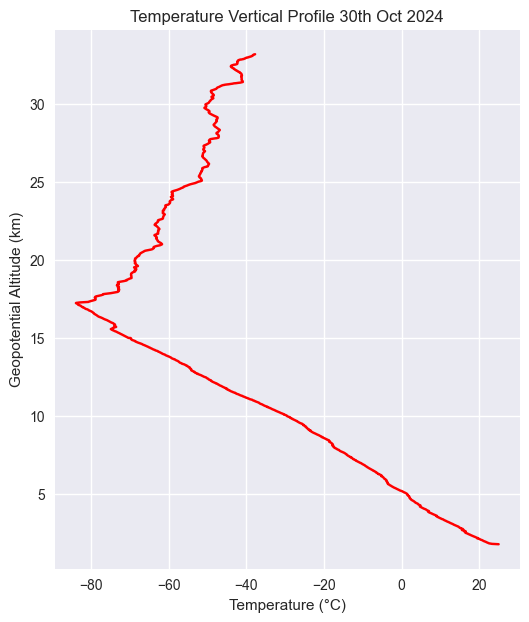

In [33]:
import os
import glob
import pandas as pd

# pick a specific launch
base_dir    = "Ozonesondes"
year_folder = os.path.join(base_dir, "shadoz_nairobi_2024_V06")
pattern     = os.path.join(year_folder, "nairobi_20241030T07_SHADOZV06*")
launch_file = glob.glob(pattern)[0]

# find the header row
header_line_idx = None
with open(launch_file, 'r') as f:
    for idx, line in enumerate(f):
        if line.lstrip().startswith("Time") and "GeopAlt" in line and "O3_mPa" in line:
            header_line_idx = idx
            break
if header_line_idx is None:
    raise ValueError("Could not find header line containing 'Time' and 'GeopAlt'")

# skip everything before the header
skiprows    = list(range(header_line_idx)) + [header_line_idx + 1]

# read all data, selecting only the three target columns ["GeopAlt", "O3_mPa", "Temp"]
ozone = pd.read_csv(
    launch_file,
    sep=r'\s+',
    engine='python',
    skiprows=skiprows,
    header=0,
    usecols=["GeopAlt", "O3_mPa", "Temp"]
)

# inspect full DataFrame
print(ozone)

# confirm you have all rows
print(f"Extracted {ozone.shape[0]} rows and {ozone.shape[1]} columns")

# plotting

import matplotlib.pyplot as plt

# Ozone profile figure
fig_o3, ax_o3 = plt.subplots(figsize=(6, 7))
ax_o3.plot(ozone['O3_mPa'], ozone['GeopAlt'], color='blue')
ax_o3.set_xlabel('Ozone (mPa)')
ax_o3.set_ylabel('Geopotential Altitude (km)')
ax_o3.set_title('O3 Vertical Profile 30th Oct 2024')
ax_o3.grid(True)

# Temperature profile figure
fig_temp, ax_temp = plt.subplots(figsize=(6, 7))
ax_temp.plot(ozone['Temp'], ozone['GeopAlt'], color='red')
ax_temp.set_xlabel('Temperature (°C)')
ax_temp.set_ylabel('Geopotential Altitude (km)')
ax_temp.set_title('Temperature Vertical Profile 30th Oct 2024')
ax_temp.grid(True)



plt.show()


In [34]:
import pandas as pd
from pathlib import Path

# 1. Configuration
base_dir = Path("Ozonesondes")
years    = range(2021, 2024)           # 2015…2024
exts     = {".txt", ".dat", ".tab"}    # accepted file extensions

records = []

# 2. Loop through each year’s folder and each launch file
for yr in years:
    year_dir = base_dir / f"shadoz_nairobi_{yr}_V06"
    if not year_dir.is_dir():
        print(f"WARNING: missing {year_dir}")
        continue

    for fn in year_dir.iterdir():
        if fn.suffix.lower() not in exts:
            continue

        # 2a. Find the header line
        with fn.open() as f:
            for idx, line in enumerate(f):
                if line.lstrip().startswith("Time") and "O3_mPa" in line:
                    header_idx, header_line = idx, line
                    break
            else:
                print(f" SKIP {fn.name}: no data header found")
                continue

        # 2b. Read only GeopAlt and O3_mPa
        cols = header_line.strip().split()
        df = pd.read_csv(
            fn,
            sep=r'\s+',
            engine='python',           # needed for regex sep
            names=cols,
            skiprows=header_idx + 1,
            usecols=["GeopAlt", "O3_mPa"],
            na_values=9000,
            comment="C"
        )

        # 2c. Coerce to numeric & drop bad rows
        df[["GeopAlt", "O3_mPa"]] = df[["GeopAlt", "O3_mPa"]].apply(
            pd.to_numeric, errors="coerce"
        )
        df = df.dropna(subset=["GeopAlt", "O3_mPa"])
        if df.empty:
            print(f" SKIP {fn.name}: no valid data")
            continue

        # 2d. Tag with year
        df["Year"] = yr
        records.append(df)

# 3. Build the full ozonesondes DataFrame
ozonesondes = pd.concat(records, ignore_index=True)

# 4. Sort & reset index
ozonesondes = ozonesondes.sort_values(["Year", "GeopAlt"]).reset_index(drop=True)

# 5. Inspect
print(ozonesondes.head(20))
print(f"\nTotal rows: {len(ozonesondes)}")


    GeopAlt  O3_mPa  Year
0     1.790  2.4230  2021
1     1.790  3.5337  2021
2     1.790  2.5918  2021
3     1.790  2.2461  2021
4     1.790  2.5330  2021
5     1.790  2.9494  2021
6     1.790  1.9874  2021
7     1.790  2.3259  2021
8     1.790  1.4759  2021
9     1.790  2.3283  2021
10    1.792  2.4193  2021
11    1.793  2.4194  2021
12    1.795  2.4194  2021
13    1.795  2.3367  2021
14    1.796  2.2661  2021
15    1.797  2.0215  2021
16    1.797  2.3638  2021
17    1.798  2.4707  2021
18    1.798  2.9789  2021
19    1.799  2.2906  2021

Total rows: 404786


C:\Users\Frank Mutuku\AppData\Local\Temp\ipykernel_5024\1644867513.py:77: UserWarning: Glyph 8323 (\N{SUBSCRIPT THREE}) missing from font(s) Arial.
  plt.tight_layout()
d:\WORLD_OZONE_DAY\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8323 (\N{SUBSCRIPT THREE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


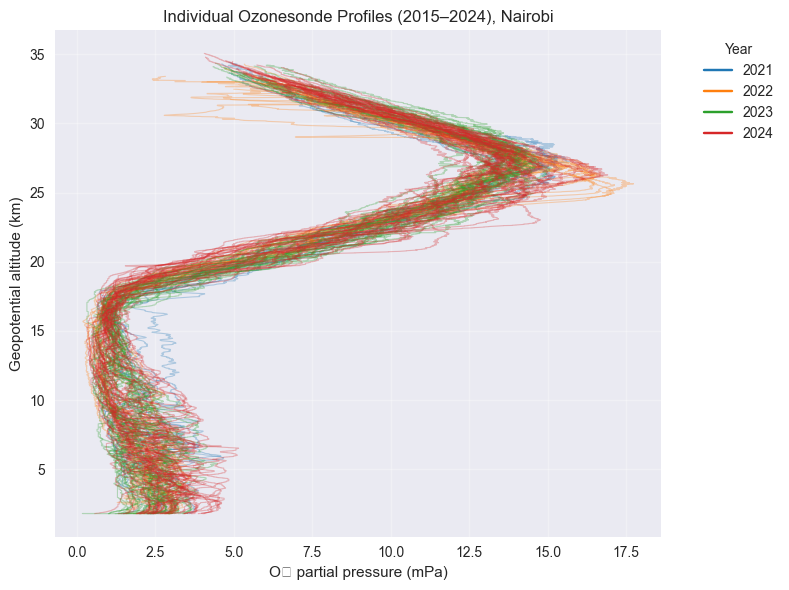

In [35]:
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

# 1. Setup
base_dir = Path("Ozonesondes")
years    = range(2021, 2025)         # now covers 2021, 2022, 2023, 2024
exts     = {".txt", ".dat", ".tab"}  # accepted extensions

# 2. Prepare figure
fig, ax = plt.subplots(figsize=(8, 6))
cmap   = plt.get_cmap("tab10")
colors = {yr: cmap(i % cmap.N) for i, yr in enumerate(years)}

# 3. Loop over each file and plot its profile
for yr in years:
    year_dir = base_dir / f"shadoz_nairobi_{yr}_V06"
    if not year_dir.is_dir():
        continue

    for fn in year_dir.iterdir():
        if fn.suffix.lower() not in exts:
            continue

        # 3a) locate header
        with fn.open() as f:
            for i, line in enumerate(f):
                if line.lstrip().startswith("Time") and "O3_mPa" in line:
                    header_idx  = i
                    header_line = line
                    break
            else:
                continue

        # 3b) read geopotential altitude & ozone
        cols = header_line.strip().split()
        df   = pd.read_csv(
            fn,
            sep=r"\s+",
            engine="python",
            names=cols,
            skiprows=header_idx + 1,
            usecols=["GeopAlt","O3_mPa"],
            na_values=9000,
            comment="C"
        )

        # 3c) drop invalids
        df["GeopAlt"] = pd.to_numeric(df["GeopAlt"], errors="coerce")
        df["O3_mPa"]  = pd.to_numeric(df["O3_mPa"],  errors="coerce")
        df = df.dropna(subset=["GeopAlt","O3_mPa"])
        if df.empty:
            continue

        # 3d) plot
        ax.plot(
            df["O3_mPa"],
            df["GeopAlt"],
            color=colors[yr],
            alpha=0.3,
            linewidth=0.8
        )

# 4. Finalize plot
ax.set_xlabel("O₃ partial pressure (mPa)")
ax.set_ylabel("Geopotential altitude (km)")
ax.set_title("Individual Ozonesonde Profiles (2015–2024), Nairobi")
ax.grid(alpha=0.3)

# 5. Legend
for yr in years:
    ax.plot([], [], color=colors[yr], label=str(yr))
ax.legend(title="Year", bbox_to_anchor=(1.05,1), loc="upper left")

plt.tight_layout()
plt.show()


In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np

base_dir = Path("Ozonesondes")
years    = range(2021, 2025)
exts     = {".txt", ".dat", ".tab"}

all_files = []
for yr in years:
    year_dir = base_dir / f"shadoz_nairobi_{yr}_V06"
    if not year_dir.exists():
        print(f"⚠️ Missing folder: {year_dir}")
        continue

    # recursive find by extension
    files = []
    for ext in exts:
        files.extend(year_dir.rglob(f"*{ext}"))
    files = sorted(files)
    print(f"{yr}: found {len(files)} files ({len(files)/4:.1f} launches/month if uniform)")

    all_files.extend(files)

    # define altitude bin size
bin_width = 0.1  # km

cols = [
    "Time","Press","GeopAlt","Temp","RH","O3_mPa",
    "O3_ppmv","O3_DU","Wind_Dir","Wind_Spd","TPump",
    "O3CellI","GPS_Lat","GPS_Lon","GPS_Alt"
]

records = []

for fn in all_files:
    lines = fn.read_text().splitlines()

    # 1. extract launch date
    dt_line = next((L for L in lines if L.startswith("Launch Date")), None)
    if not dt_line:
        continue
    dt = pd.to_datetime(dt_line.split(":",1)[1].strip(),
                       format="%Y%m%d", errors="coerce")
    if pd.isna(dt):
        continue
    year, month = dt.year, dt.month

    # 2. find numeric block header
    try:
        hdr_i = next(i for i, L in enumerate(lines)
                     if L.strip().startswith("Time") and "O3_mPa" in L)
    except StopIteration:
        continue

    # 3. read profile
    df = pd.read_csv(
        fn,
        sep=r"\s+",
        engine="python",
        names=cols,
        header=None,
        skiprows=hdr_i + 2,
        na_values="9000"
    ).dropna(subset=["GeopAlt","O3_mPa"])
    if df.empty:
        continue

    # 4. bin the altitude
    df["GeopAlt_bin"] = (df["GeopAlt"] / bin_width).round() * bin_width

    # 5. keep only one value per alt-bin per flight
    df_bin = (
        df
        .groupby("GeopAlt_bin", as_index=False)
        .agg(O3_mPa=("O3_mPa","mean"))
    )

    # 6. tag and collect
    df_bin["Year"]  = year
    df_bin["Month"] = month
    records.append(df_bin[["Year","Month","GeopAlt_bin","O3_mPa"]])

# Combine all launches
master = pd.concat(records, ignore_index=True)

monthly = (
    master
    .groupby(["Year","Month","GeopAlt_bin"], as_index=False)
    .agg(O3_mPa=("O3_mPa","mean"))
    .sort_values(["Year","Month","GeopAlt_bin"])
)

# Pivot for visual inspection
monthly["Year-Month"] = (
    monthly["Year"].astype(str)
    + "-"
    + monthly["Month"].astype(str).str.zfill(2)
)
pivot = monthly.pivot(
    index="GeopAlt_bin",
    columns="Year-Month",
    values="O3_mPa"
)

print(pivot.round(3).head(10))


# tag flight by file-stem to count unique launches
tags = []
for fn in all_files:
    month_dt = pd.to_datetime(  # same logic as above
        next(L for L in fn.read_text().splitlines() if L.startswith("Launch Date"))
        .split(":",1)[1].strip(),
        format="%Y%m%d"
    )
    tags.append((month_dt.year, month_dt.month, fn.stem))

flight_counts = (
    pd.DataFrame(tags, columns=["Year","Month","Flight"])
      .drop_duplicates()
      .groupby(["Year","Month"])
      .size()
      .unstack(fill_value=0)
)
print(flight_counts)




2021: found 10 files (2.5 launches/month if uniform)
2022: found 17 files (4.2 launches/month if uniform)
2023: found 32 files (8.0 launches/month if uniform)
2024: found 36 files (9.0 launches/month if uniform)
Year-Month   2021-10  2021-11  2021-12  2022-01  2022-02  2022-03  2022-04  \
GeopAlt_bin                                                                  
1.8            2.896    2.632    2.074    2.844    2.165    2.567    2.541   
1.9            2.992    2.746    2.191    2.878    2.171    2.640    2.659   
2.0            3.076    2.819    2.294    2.947    2.218    2.728    2.773   
2.1            3.120    2.825    2.323    3.034    2.283    2.790    2.830   
2.2            3.132    2.821    2.338    3.074    2.344    2.827    2.853   
2.3            3.121    2.813    2.349    3.088    2.311    2.832    2.862   
2.4            3.071    2.812    2.367    3.065    2.303    2.795    2.839   
2.5            3.019    2.777    2.382    3.052    2.190    2.758    2.804   
2.6     

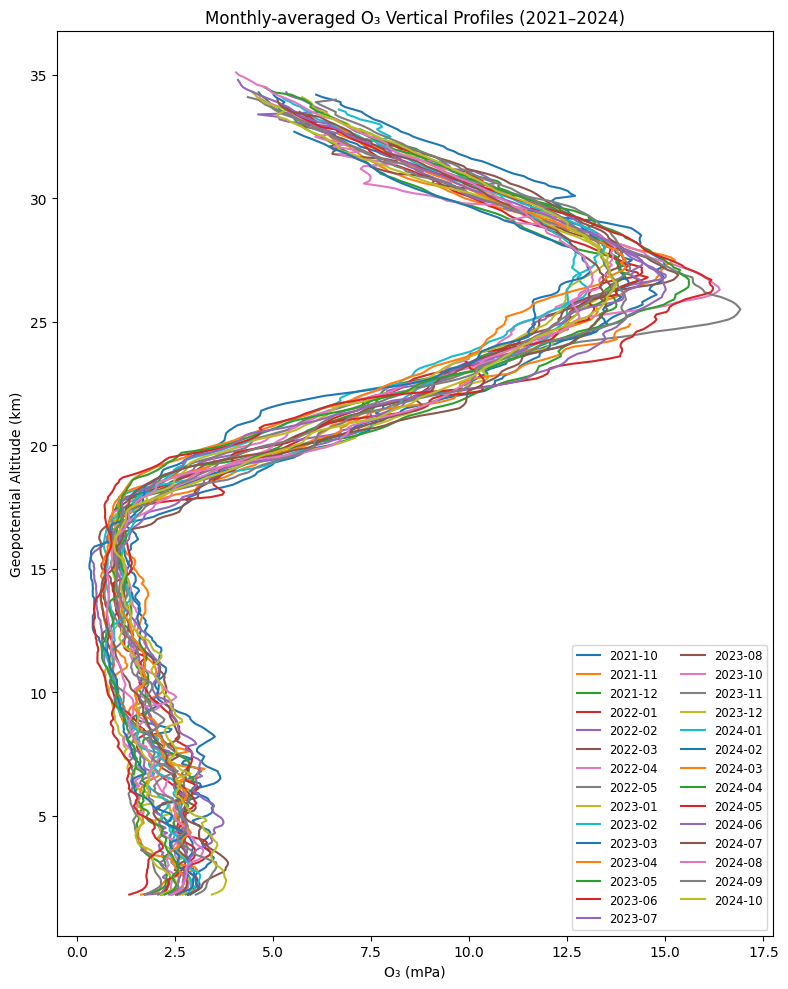

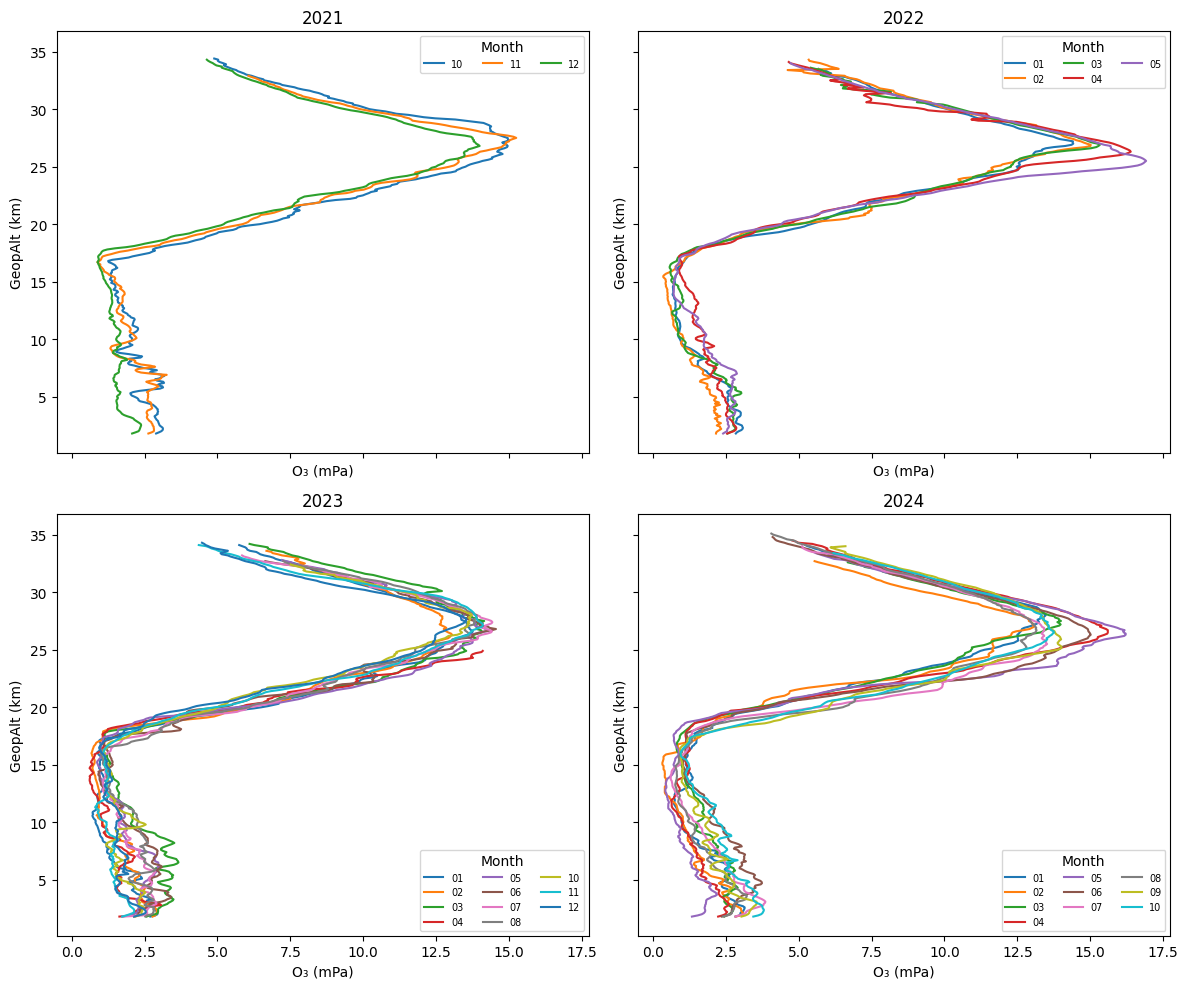

In [15]:
import matplotlib.pyplot as plt

# pivot.index = GeopAlt_bin (km)
# pivot.columns = 'YYYY-MM'

plt.figure(figsize=(8, 10))

for col in pivot.columns:
    plt.plot(pivot[col], pivot.index, label=col)

# Altitude increases upward by default—do NOT invert y!
# plt.gca().invert_yaxis()

plt.xlabel("O₃ (mPa)")
plt.ylabel("Geopotential Altitude (km)")
plt.title("Monthly-averaged O₃ Vertical Profiles (2021–2024)")

plt.legend(loc="lower right", fontsize="small", ncol=2)

plt.tight_layout()
plt.show()




years = ["2021", "2022", "2023", "2024"]
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
axes = axes.ravel()

for ax, yr in zip(axes, years):
    # select only the 12 months of this year
    cols = [c for c in pivot.columns if c.startswith(yr)]
    for c in cols:
        ax.plot(pivot[c], pivot.index, label=c.split("-")[1])  # label by MM
    ax.invert_yaxis()
    ax.set_title(yr)
    ax.set_xlabel("O₃ (mPa)")
    ax.set_ylabel("GeopAlt (km)")
    ax.legend(title="Month", fontsize="x-small", ncol=3)

plt.tight_layout()
plt.show()
